In [1]:
# Load the lightning model from checkpoint

import pytorch_lightning as pl
import torch
import numpy as np
from src.failure_model import ToxicClassifier
from src.datasets import PromptOnlyDataset, PropDataset

cal_prompts = PromptOnlyDataset("data/rtp/split_1_0.5_0.1_0.2_0.2/cal.pkl")

cal_prompts.data = cal_prompts.data[-100:]

# Examine the model weights in the checkpoint before loading
checkpoint = torch.load("saved/Prop_RTP_ModernBERT/lightning_logs/version_26/checkpoints/epoch=4-step=495.ckpt")

model = ToxicClassifier.load_from_checkpoint("saved/Prop_RTP_ModernBERT/lightning_logs/version_26/checkpoints/epoch=4-step=495.ckpt")

taus = torch.tensor(np.logspace(-3, 0, 20))
# Get the index closest to 0.1
idx = (taus - 0.1).abs().argmin()
model.set_taus(taus)
model.eval()

trainer = pl.Trainer()
pred = trainer.predict(model, cal_prompts)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dahen/miniconda3/envs/llm-survival/lib/python3.13/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/dahen/miniconda3/envs/llm-survival/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dahen/miniconda3/envs/llm-survival/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency

Predicting: |          | 0/? [00:00<?, ?it/s]

In [2]:
print(pred)

[{'proba': tensor([0.0050]), 'tau': tensor([  1.,   1.,   1.,   1.,   1.,   2.,   2.,   3.,   4.,   6.,   8.,  12.,
         17.,  24.,  36.,  54.,  82., 132., 238.,  inf], dtype=torch.float64)}, {'proba': tensor([1.3546e-05]), 'tau': tensor([7.4000e+01, 1.0700e+02, 1.5300e+02, 2.2100e+02, 3.1700e+02, 4.5700e+02,
        6.5700e+02, 9.4700e+02, 1.3660e+03, 1.9730e+03, 2.8550e+03, 4.1420e+03,
        6.0340e+03, 8.8430e+03, 1.3081e+04, 1.9638e+04, 3.0226e+04, 4.8743e+04,
        8.7706e+04,        inf], dtype=torch.float64)}, {'proba': tensor([0.1876]), 'tau': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 4.,
        6., inf], dtype=torch.float64)}, {'proba': tensor([0.0033]), 'tau': tensor([  1.,   1.,   1.,   1.,   2.,   2.,   3.,   4.,   6.,   9.,  12.,  17.,
         25.,  37.,  54.,  81., 124., 200., 359.,  inf], dtype=torch.float64)}, {'proba': tensor([9.8481e-05]), 'tau': tensor([1.1000e+01, 1.5000e+01, 2.2000e+01, 3.1000e+01, 4.4000e+01, 6.3000e+01,

In [ ]:
# Create generation and rating backends
from src.rating.detoxify import DetoxifyRater
from src import utils
from src.generation.vanilla_model import VanillaGenerator
from src.survival_runner import (
    SurvivalRunner,
    SurvivalResult,
    default_toxicity_func,
    default_text_prep_func,
)

rater_backend = DetoxifyRater(
    model_type="original",
    amp=True,
)

hf_key = utils.api_key_from_file("HF_KEY.txt")

# TODO: FIX ARGS
generator_backend = VanillaGenerator(
    model_name="meta-llama/Llama-3.2-3B",
    hf_token=hf_key,
    max_input_tokens=40,
    max_output_tokens=30,
)

batch_size = 1500

survival_runner = SurvivalRunner(
    generator=generator_backend,
    rater=rater_backend,
    max_attempts=torch.tensor([item['tau'][idx].item() for item in pred]),
    toxicity_func=default_toxicity_func,
    text_prep_func=lambda gen: gen.prompt + gen.output,
    conserve_memory=False,
)

survival_results = survival_runner.generate(
    prompts=cal_prompts,
    batch_size=batch_size,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
survival_list = [result for result in survival_results]

Processing Prompts:   0%|          | 0/100 [00:00<?, ?it/s]

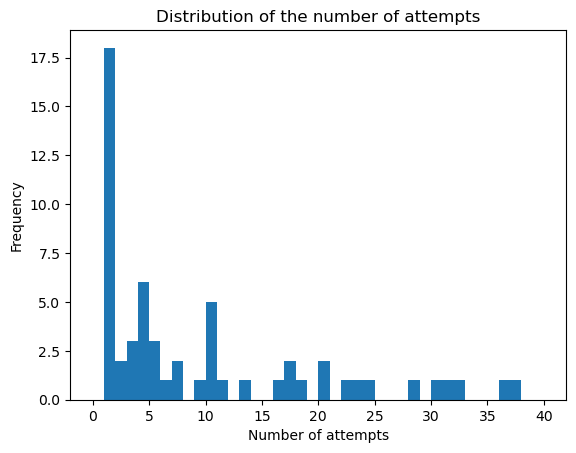

In [ ]:
lens = [len(survival_list[i].ratings) for i in range(len(survival_list))]
# plot the distribution of the number of attempts
import matplotlib.pyplot as plt
plt.hist(lens, bins=range(0, 41, 1))
plt.xlabel("Number of attempts")
plt.ylabel("Frequency")
plt.title("Distribution of the number of attempts")
plt.show()

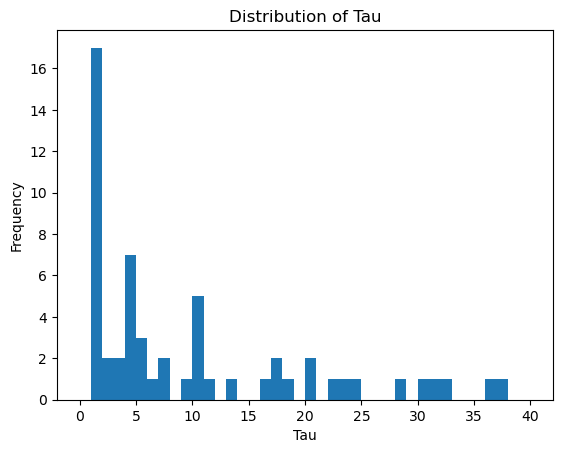

In [19]:
# Plot the distribution of [item['tau'][idx].item() for item in pred]
plt.hist([item['tau'][idx].item() for item in pred], bins=range(0, 41, 1))
plt.xlabel("Tau")
plt.ylabel("Frequency")
plt.title("Distribution of Tau")
plt.show()

In [27]:
max_attempts = [survival_list[i].max_attempts.item() for i in range(len(survival_list))]
taus = [item['tau'][idx].item() for item in pred]

max_attempts = torch.tensor(max_attempts).sort().values
taus = torch.tensor(taus).sort().values
lens = torch.tensor(lens).sort().values

# Check if they are the same
print((taus >= lens).all())

tensor(True)


/tmp/ipykernel_509526/2455579458.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lens = torch.tensor(lens).sort().values


In [86]:
# Force reimport
import importlib
import src.conformal
importlib.reload(src.conformal)
from src.conformal import conformalize

trainer = pl.Trainer()
target_taus = torch.tensor([0.1])
canidate_taus = torch.tensor(np.logspace(-5, -1, 200))

a_hat, max_est = conformalize(trainer=trainer, model=model, target_taus=target_taus, canidate_taus=canidate_taus, X=cal_prompts, generation_backend=generator_backend, rating_backend=rater_backend, 
                              budget_per_sample=20, share_budget=True, min_sample_size=0.05, text_prep_func=lambda gen: gen.prompt + gen.output)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Processing Prompts:   0%|          | 0/100 [00:00<?, ?it/s]

Total budget used per sample is 11.9
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.     

In [87]:
print(a_hat)
print(max_est)

tensor([0.0047], dtype=torch.float64)
706
